# 📈 Time Series Analysis and Forecasting of IPAP

This notebook presents the analysis and forecasting of a time series corresponding to the Tourist Apartment Price Index (IPAP) in Spain for the period 2003-2022, with a total of 252 data points.

## 📦 Imports and Setup

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings

warnings.filterwarnings("ignore")

## 📊 Data Loading and Preprocessing

In [2]:
# Load the IPAP dataset
ipap = pd.read_excel('../data/IPAP.xlsx', engine='openpyxl')
ipap.head(5)

,Periodo,Índice
0,2003M01,101.02
1,2003M02,100.27
2,2003M03,100.1
3,2003M04,102.56
4,2003M05,101.24


In [3]:
# Format the 'Periodo' column and set it as index
ipap['Periodo'] = ipap['Periodo'].str.replace('M', '-').str.strip()
ipap['Periodo'] = pd.to_datetime(ipap['Periodo'], format='%Y-%m')

# Convert to numeric and fill missing values
S_ipap = ipap.set_index('Periodo')[['Índice']]
S_ipap.head(5)

,Índice
Periodo,
2003-01-01,101.02
2003-02-01,100.27
2003-03-01,100.1
2003-04-01,102.56
2003-05-01,101.24


In [4]:
# Convert 'Índice' to numeric and check for missing values
S_ipap['Índice'] = pd.to_numeric(S_ipap['Índice'], errors='coerce')
print(S_ipap.isnull().sum())

Índice    1
dtype: int64


In [5]:
# Convert NaN values to 0
S_ipap = S_ipap.fillna(0)
print(S_ipap.isnull().sum())

Índice    0
dtype: int64


## 🔍 Time Series Visualization

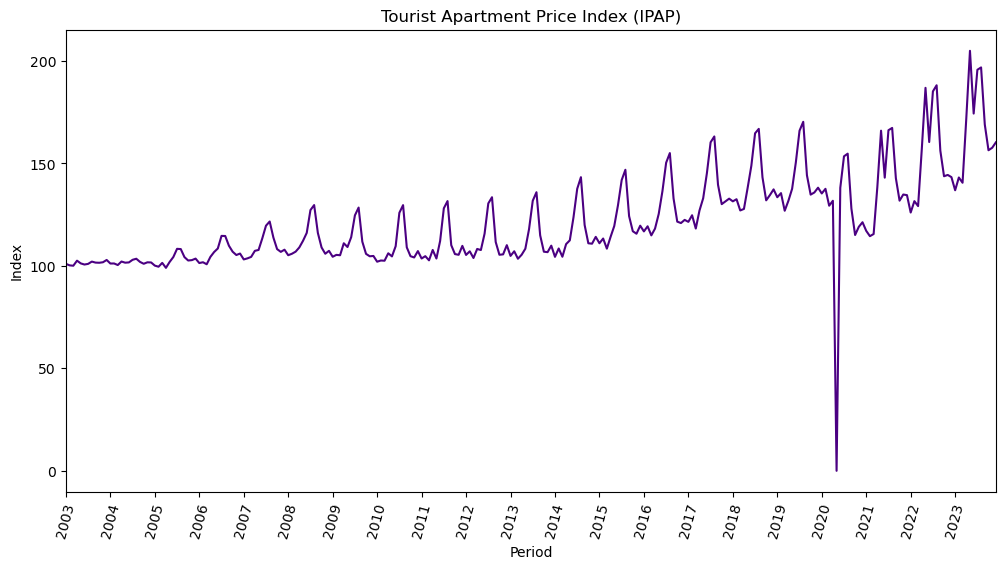

In [6]:
# Visualize the time series
S_ipap.plot(figsize=(12, 6), color='indigo')
plt.title('Tourist Apartment Price Index (IPAP)')
plt.xlabel('Period')
plt.ylabel('Index')
plt.xticks(ticks=S_ipap.index[::12], labels=S_ipap.index[::12].strftime('%Y')) 
plt.xticks(rotation=75)
plt.legend().remove()
plt.show()

Due to travel restrictions because of COVID-19, a sharp drop appears in the IPAP index during 2020. 

## 🎯 Seasonal Decomposition

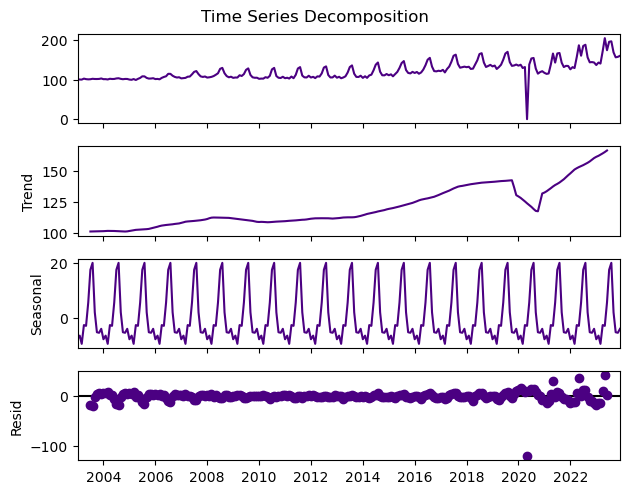

In [7]:
# Additive decomposition of the time series
Additive_decomposition = seasonal_decompose(S_ipap, model='additive', period=12)

# Visualize the decomposition
fig = Additive_decomposition.plot()
for ax in fig.axes:
    if ax.lines:
        ax.lines[0].set_color('indigo')
plt.suptitle("Time Series Decomposition", y=1.02)
plt.show()

In [8]:
# Stational components of the decomposition
print(Additive_decomposition.seasonal[:12])

Periodo
2003-01-01    -7.925295
2003-02-01    -6.604087
2003-03-01    -9.616462
2003-04-01    -2.731816
2003-05-01    -3.033649
2003-06-01     5.537830
2003-07-01    17.465413
2003-08-01    20.019747
2003-09-01     1.924038
2003-10-01    -5.367983
2003-11-01    -5.559295
2003-12-01    -4.108441
Name: seasonal, dtype: float64


The highest seasonality coefficient is 20.019747, corresponding to the month of August; therefore, during that period, the IPAP is 20.02 higher than the annual average. On the other hand, the lowest seasonality coefficient is -9.616462, corresponding to the month of March, in which the IPAP is -9.6 times lower than the annual average.

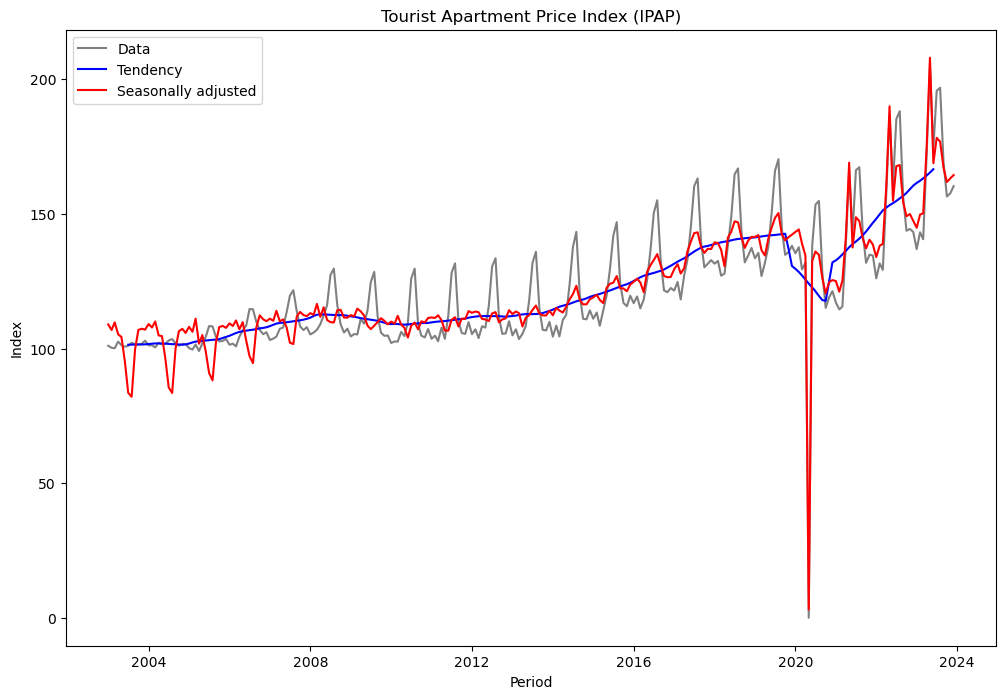

In [9]:
# Visualize the time series with trend and seasonally adjusted series
S_Adjusted = S_ipap['Índice'] - Additive_decomposition.seasonal
plt.figure(figsize=(12, 8))
plt.plot(S_ipap, label='Data', color='gray')
plt.plot(Additive_decomposition.trend, label='Tendency', color='blue')
plt.plot(S_Adjusted, label='Seasonally adjusted', color='red')
plt.xlabel('Period')
plt.ylabel('Index')
plt.title('Tourist Apartment Price Index (IPAP)')
plt.legend()
plt.show()

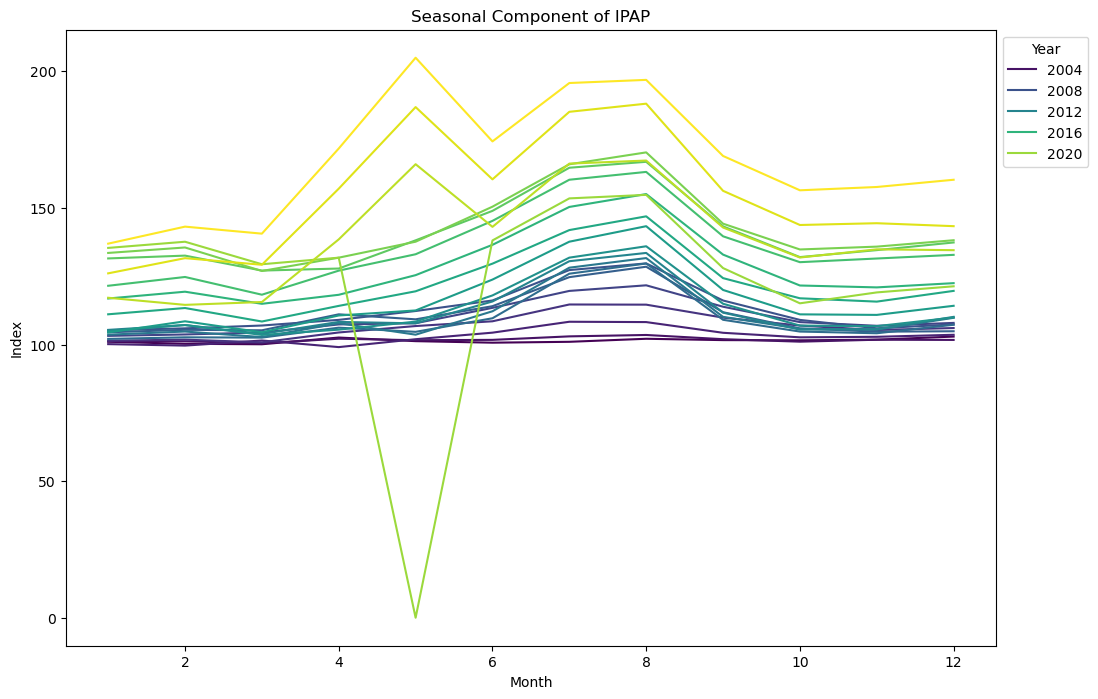

In [10]:
# Visualize the seasonal component
plt.figure(figsize=(12, 8))
sns.lineplot(
    x = S_ipap.index.month, 
    y = S_ipap['Índice'],
    hue = S_ipap.index.year, 
    palette='viridis'
    )
plt.xlabel('Month')
plt.ylabel('Index')
plt.title('Seasonal Component of IPAP')
plt.legend(title = 'Year', loc = 'upper left', bbox_to_anchor = (1, 1))
plt.show()

## ✂️ Train-Test Split

In [11]:
# Considering that there are 252 observations in total, the last period (last 12 samples) can be taken for testing

# Determination of the subgroup for training
train = S_ipap[:240]

# Determination of the subgroup for testing
test = S_ipap[240:]

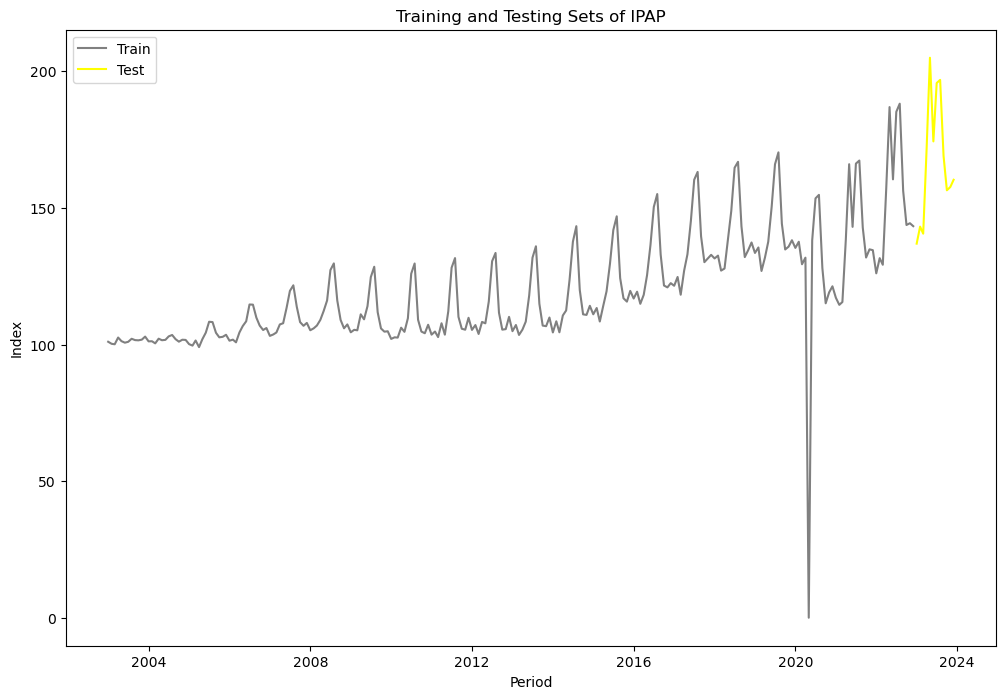

In [12]:
# Visualize the training and testing sets
plt.figure(figsize=(12,8))
plt.plot(train, label='Train', color='gray')
plt.plot(test, label='Test', color='yellow')
plt.legend()
plt.title('Training and Testing Sets of IPAP')
plt.xlabel('Period')
plt.ylabel('Index')
plt.show()

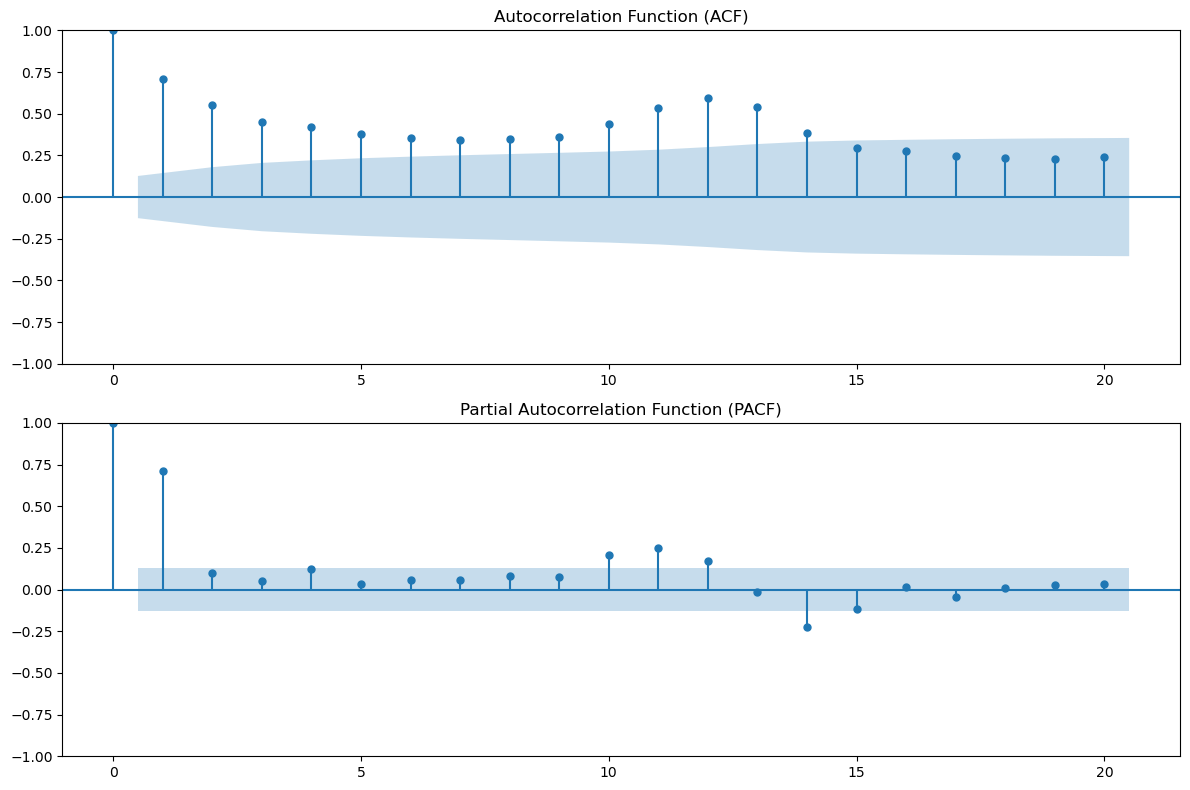

In [13]:
# Correlograms of the autocorrelation function (ACF) and partial autocorrelation function (PACF) of IPAP
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(train, lags=20, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')
plot_pacf(train, lags=20, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

- As can be seen, the ACF correlogram decays progressively in a sinusoidal manner, indicating a clear trend and seasonality. However, for this very reason, the signal is non-stationary (its mean and variance are not constant).

- In the PACF correlogram, only one significant value is displayed at 1, and then the values fall rapidly to almost zero, reaching 10-13, when it increments again,

## 🧊 Smoothing Models

### Simple Exponential Smooting

In [14]:
# Generate a simple exponential smoothing model
model_simple = SimpleExpSmoothing(train, initialization_method="estimated").fit()
fcast_simple = model_simple.forecast(12)
print(model_simple.params_formatted)

                  name       param  optimized
smoothing_level  alpha    0.552984       True
initial_level      l.0  100.813634       True


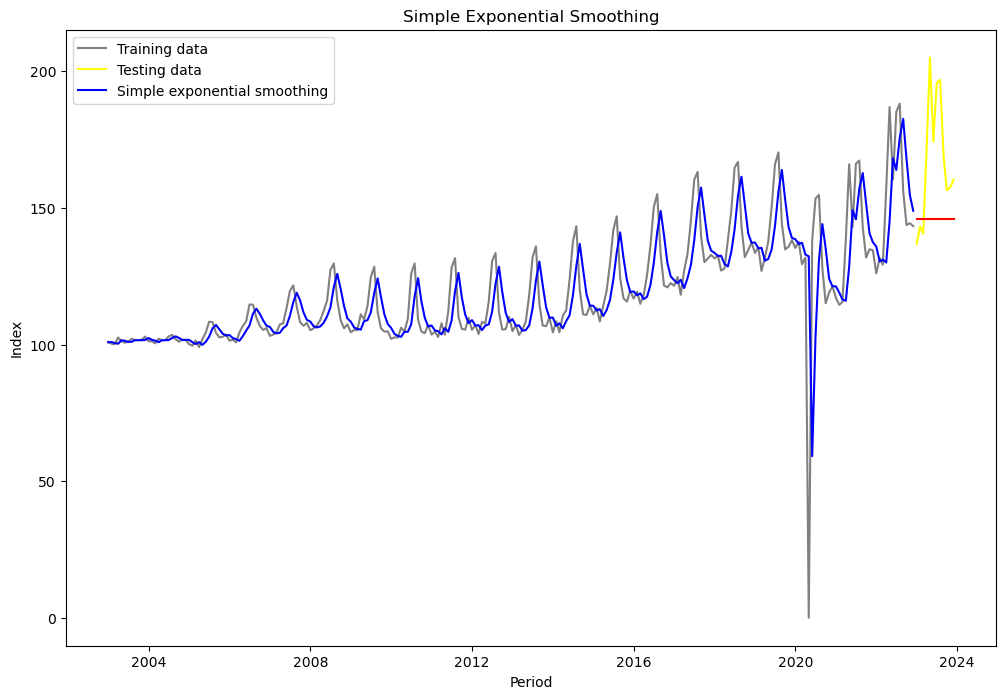

In [15]:
# Visualize the training and testing sets with the simple exponential smoothing model
plt.figure(figsize = (12, 8))
plt.plot(train, label='Training data', color='gray')
plt.plot(test, label='Testing data', color='yellow')
plt.plot(model_simple.fittedvalues, label='Simple exponential smoothing', color='blue')
plt.plot(fcast_simple,color='red')
plt.xlabel('Period')
plt.ylabel('Index')
plt.title('Simple Exponential Smoothing')
plt.legend()
plt.show()

In [16]:
# Prediction results
print(fcast_simple)

2023-01-01    145.851143
2023-02-01    145.851143
2023-03-01    145.851143
2023-04-01    145.851143
2023-05-01    145.851143
2023-06-01    145.851143
2023-07-01    145.851143
2023-08-01    145.851143
2023-09-01    145.851143
2023-10-01    145.851143
2023-11-01    145.851143
2023-12-01    145.851143
Freq: MS, dtype: float64


### Holt Smoothing

In [17]:
# generate Holt Smoothing model
model_holt = Holt(train, initialization_method="estimated").fit()
fcast_holt = model_holt.forecast(12)
print(model_holt.params_formatted)

                  name       param  optimized
smoothing_level  alpha    0.550663       True
smoothing_trend   beta    0.000000       True
initial_level      l.0  100.683535       True
initial_trend      b.0    0.185506       True


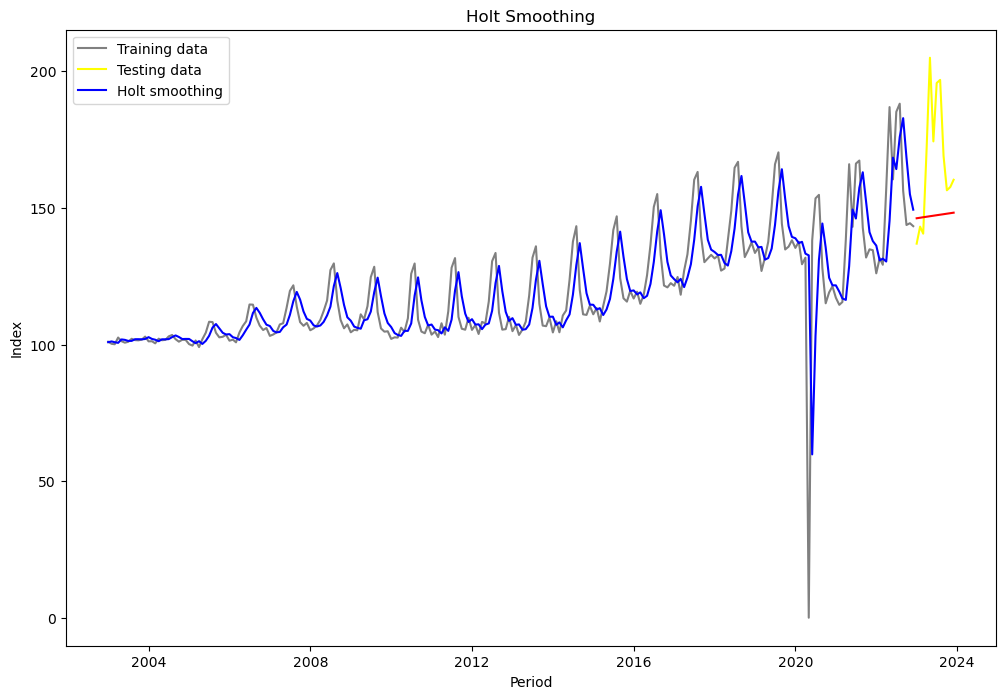

In [18]:
# Visualize the training and testing sets with the Holt Smoothing model
plt.figure(figsize=(12, 8))
plt.plot(train, label='Training data', color='gray')
plt.plot(test, label='Testing data', color='yellow')
plt.plot(model_holt.fittedvalues, label='Holt smoothing', color='blue')
plt.plot(fcast_holt,color='red')
plt.xlabel('Period')
plt.ylabel('Index')
plt.title('Holt Smoothing')
plt.legend()
plt.show()

In [19]:
# Prediction results
print(fcast_holt)

2023-01-01    146.226264
2023-02-01    146.411770
2023-03-01    146.597276
2023-04-01    146.782783
2023-05-01    146.968289
2023-06-01    147.153796
2023-07-01    147.339302
2023-08-01    147.524808
2023-09-01    147.710315
2023-10-01    147.895821
2023-11-01    148.081327
2023-12-01    148.266834
Freq: MS, dtype: float64


### Holt's Damped Trend Smoothing

In [20]:
# Generate Holt's Damped Trend Smoothing model
model_tend_amort = Holt(train,damped_trend=True, initialization_method="estimated").fit()
fcast_tend_amort = model_tend_amort.forecast(12)
print(model_tend_amort.params_formatted)

                  name       param  optimized
smoothing_level  alpha    0.553892       True
smoothing_trend   beta    0.000002       True
initial_level      l.0  100.354443       True
initial_trend      b.0    0.261582       True
damping_trend      phi    0.995000       True


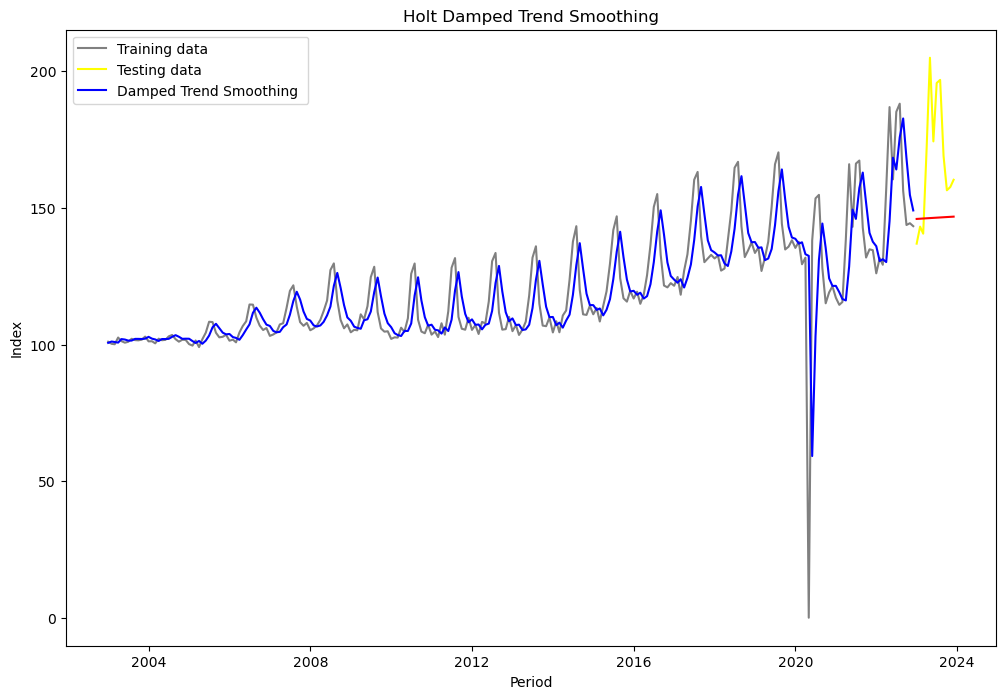

In [21]:
# Visualize the training and testing sets with the Holt's Damped Trend Smoothing model
plt.figure(figsize=(12, 8))
plt.plot(train, label='Training data', color='gray')
plt.plot(test, label='Testing data', color='yellow')
plt.plot(model_tend_amort.fittedvalues, label='Damped Trend Smoothing ', color='blue')
plt.plot(fcast_tend_amort,color='red')
plt.xlabel('Period')
plt.ylabel('Index')
plt.title('Holt Damped Trend Smoothing')
plt.legend()
plt.show()

This method adds a smoothing factor so that predictions can be better adjusted to the curve. In this case, that value (phi) is extremely close to 1, so it does not have a significant impact on the model.

In [22]:
# Prediction results
print(fcast_tend_amort)

2023-01-01    145.978713
2023-02-01    146.056887
2023-03-01    146.134670
2023-04-01    146.212064
2023-05-01    146.289072
2023-06-01    146.365694
2023-07-01    146.441933
2023-08-01    146.517791
2023-09-01    146.593270
2023-10-01    146.668371
2023-11-01    146.743096
2023-12-01    146.817448
Freq: MS, dtype: float64


### Comparison between smoothing methods


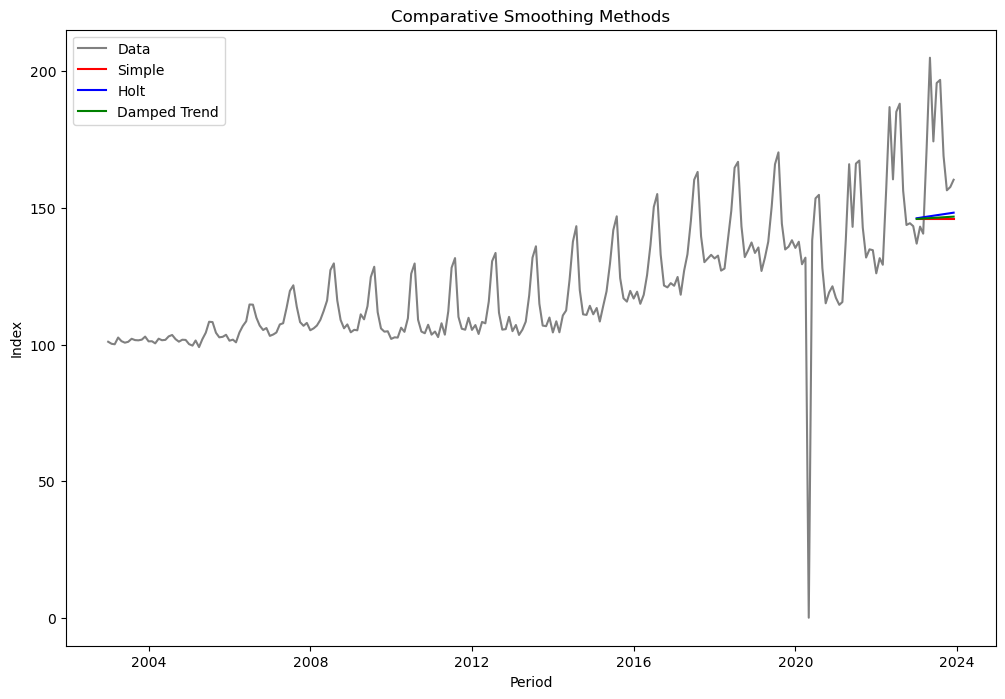

In [23]:
# Visualize the comparison between smoothing methods
plt.figure(figsize=(12, 8))
plt.plot(S_ipap, label='Data', color='gray')
plt.plot(fcast_simple, label='Simple', color='red')
plt.plot(fcast_holt, label='Holt', color='blue')
plt.plot(fcast_tend_amort,label="Damped Trend",color='green')
plt.xlabel('Period')
plt.ylabel('Index')
plt.title('Comparative Smoothing Methods')
plt.legend()
plt.show()

The comparison between the smoothing methods shows that while Simple Exponential Smoothing is effective for data without trend or seasonality, Holt's methods are more suitable for time series with these characteristics. However, after evaluating the obtained resuls, it can be proven that none of this achieve great results.

### Holt-Winters Smoothing

In [24]:
# Generate Holt-Winters Smoothing model
model_hw = ExponentialSmoothing(train, seasonal_periods = 12,trend="add",
seasonal = "add", initialization_method="estimated").fit()
fcast_hw = model_hw.forecast(12)

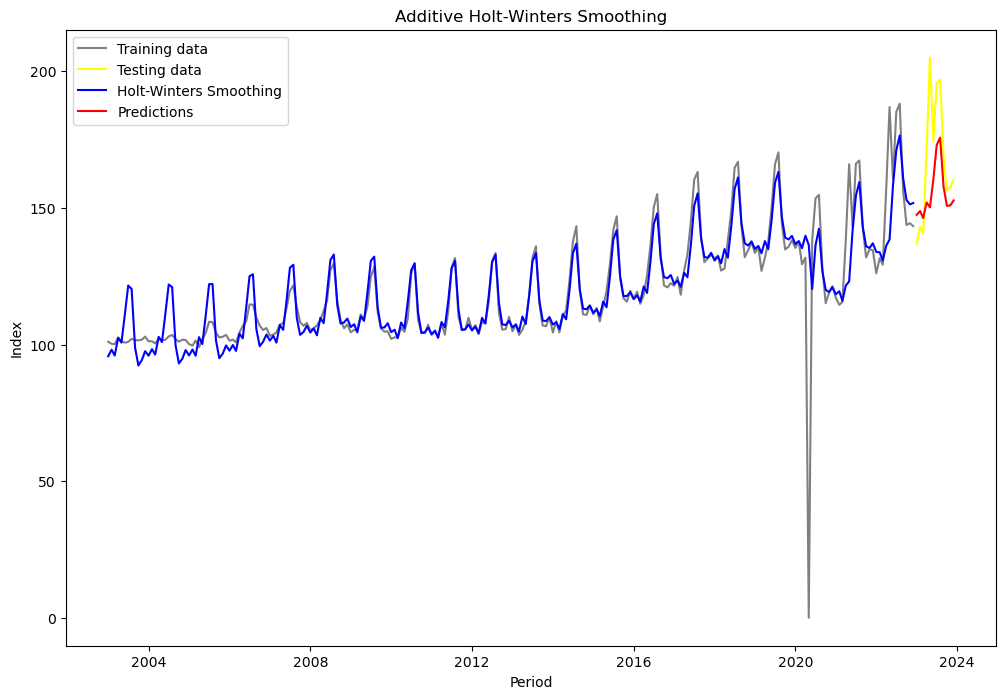

In [25]:
# Visualize the training and testing sets with the Holt-Winters Smoothing model
plt.figure(figsize=(12, 8))
plt.plot(train, label='Training data', color='gray')
plt.plot(test, label='Testing data', color='yellow')
plt.plot(model_hw.fittedvalues, label='Holt-Winters Smoothing', color='blue')
plt.plot(fcast_hw,color='red', label="Predictions")
plt.xlabel('Period')
plt.ylabel('Index')
plt.title('Additive Holt-Winters Smoothing')
plt.legend()
plt.show()

In [26]:
# Prediction results
print(fcast_hw)

2023-01-01    147.483994
2023-02-01    148.851147
2023-03-01    146.296427
2023-04-01    152.000410
2023-05-01    150.202470
2023-06-01    160.513843
2023-07-01    173.023589
2023-08-01    175.742065
2023-09-01    157.818906
2023-10-01    150.756145
2023-11-01    150.925465
2023-12-01    152.745729
Freq: MS, dtype: float64


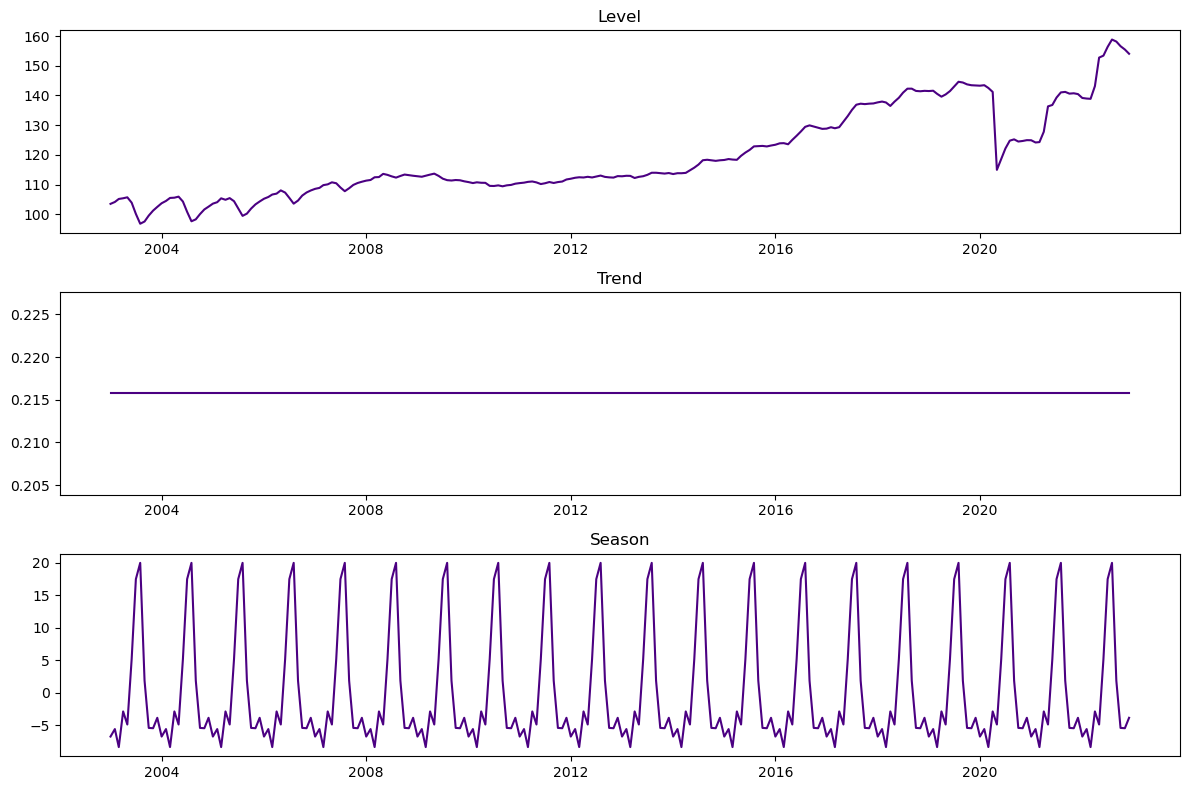

In [27]:
# Components of the Holt-Winters Smoothing model
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 8))
axes[0].plot(model_hw.level, color='indigo')
axes[0].set_title('Level')
axes[1].plot(model_hw.trend, color='indigo')
axes[1].set_title('Trend')
axes[2].plot(model_hw.season, color='indigo')
axes[2].set_title('Season')
plt.tight_layout()
plt.show()

It can be seen that the level of the series progressively increases until 2020, when it plummeted abruptly due to the crisis during the COVID-19 period. After this, the increase in the level returns to being progressive and greater than in previous years (probably also influenced by high tourist demand and current real estate inflation).

On the other hand, the trend is completely flat, indicating that there are no variations in it. And, the periods are always evident in the same way, during the busiest tourist season in Spain; that is, between May and August of each year (mainly the latter month).

## 🔁 ARIMA model

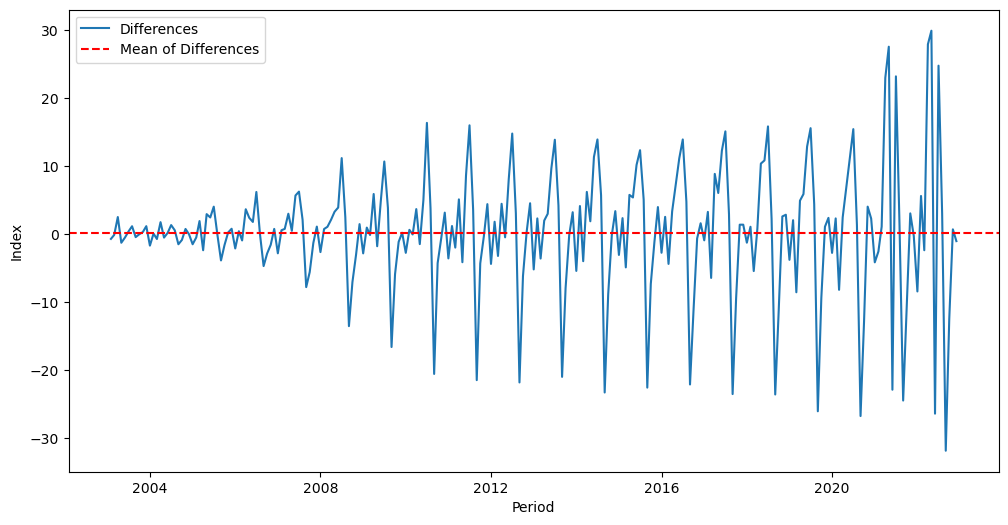

In [28]:
# Calculate the differences
train_2 = train[train != 0] # Se vuelve a perder el dato que se había rellenado con 0
differences = train_2.diff().dropna()

# Calculate the mean of the differences
avg_differences = differences['Índice'].mean() if 'Índice' in differences.columns else differences.mean()

# Visualize the differences
plt.figure(figsize=(12, 6))
plt.plot(differences, label = 'Differences')
plt.axhline(y=avg_differences, color='red', linestyle='--', label='Mean of Differences')  
plt.xlabel('Period')
plt.ylabel('Index')
plt.legend()
plt.show()

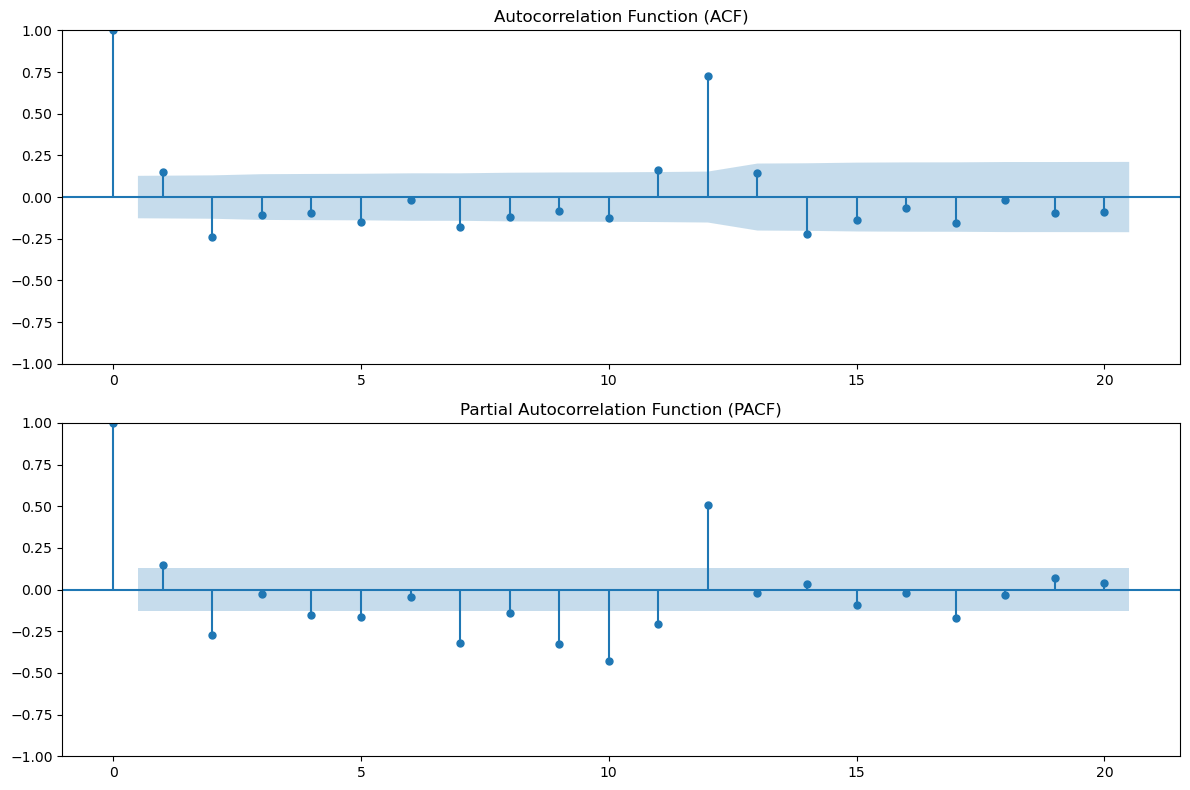

In [29]:
# Visualize the ACF and PACF of the differences
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(differences, lags=20, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')
plot_pacf(differences, lags=20, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

- This time, in the ACF representation, a change can be observed: the correlations decrease rapidly towards 0, which may indicate that the series is now more stationary. On the other hand, the signal continues to show some seasonality, as the structure before 11 and after 13 is extremely similar. In addition, from the first value, there is a significant correlation (evident again at 12), so it may be autoregressive or moving average components.

- In the case of the correlogram for PACF, a significant value is again observed at 1, but also at 12; therefore, these may be possible candidates for the order of an AR component in an ARIMA (p) model.

## 📆 Seasonal ARIMA model

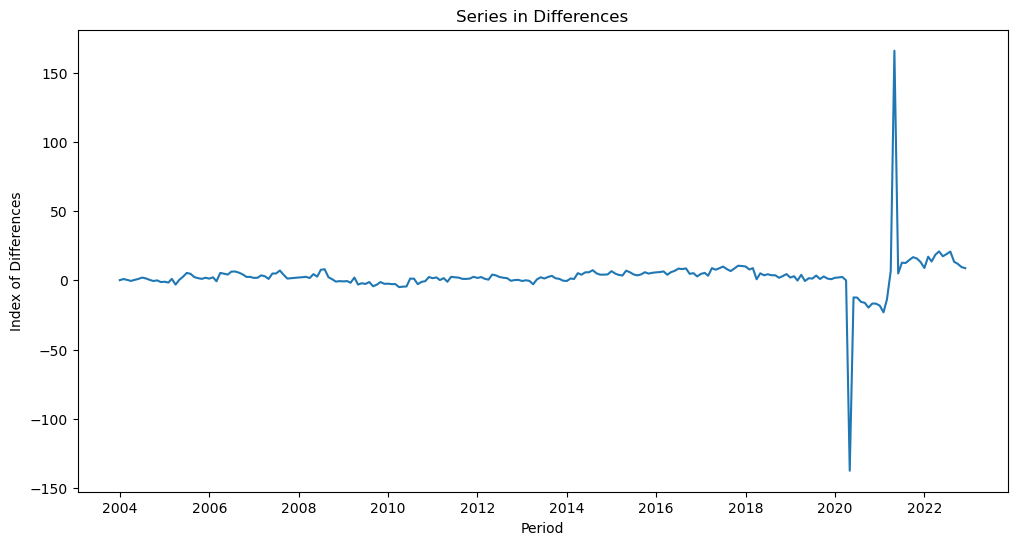

In [30]:
# Calculate the differences of seasonal order
differences = train.diff(12) 

# Visualize the differences
plt.figure(figsize=(12, 6))
plt.plot(differences)
plt.title('Series in Differences')
plt.xlabel('Period')
plt.ylabel('Index of Differences')
plt.show()

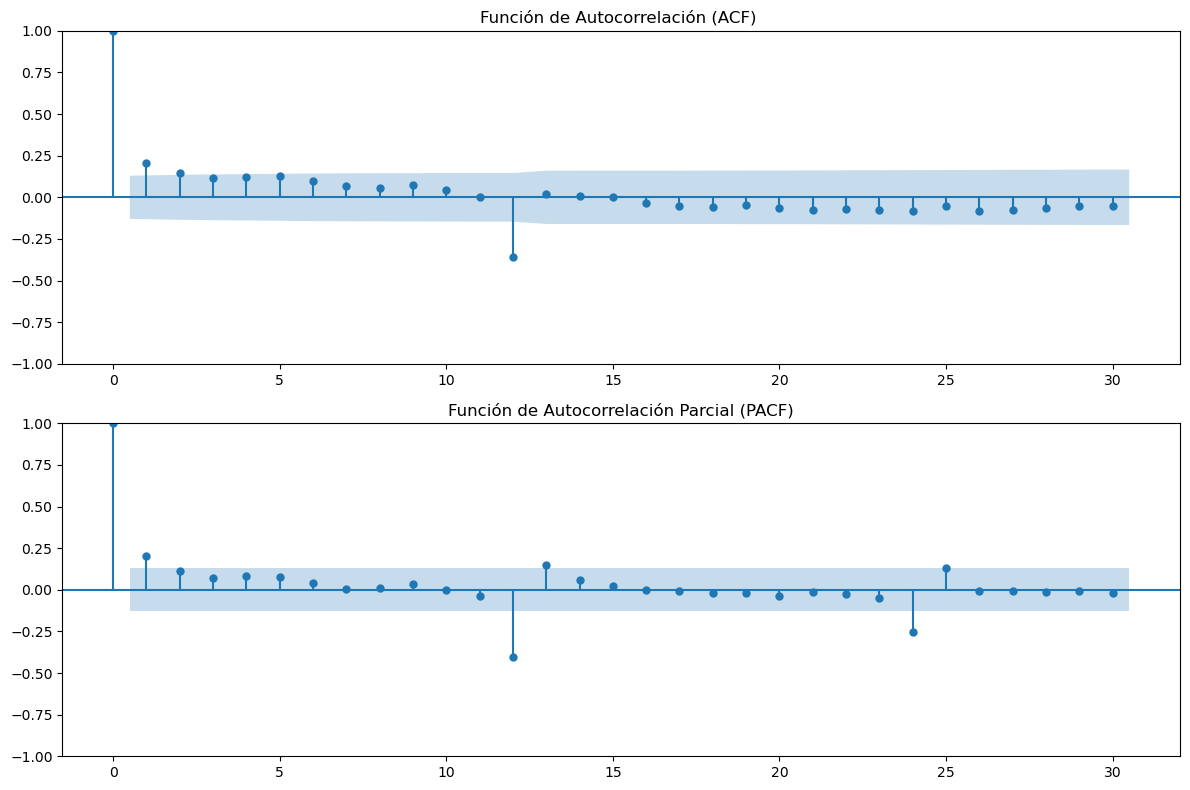

In [31]:
# Elimnate the missing values that appear at the beginning when making the differences
differences = differences.dropna()

# Visualize the correlograms ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(differences, lags=30, ax=ax1)
ax1.set_title('Función de Autocorrelación (ACF) ')
plot_pacf(differences, lags=30, ax=ax2)
ax2.set_title('Función de Autocorrelación Parcial (PACF)')
plt.tight_layout()
plt.show()

- When calculating the differences in seasonal mode, a negative autocorrelation outside the confidence interval is observed at 12, which could be due to seasonal interactions or residual patterns. Apart from this case, there is evidence of a decrease in autocorrelations, making the time signal more stationary. No other peaks are observed that could indicate more persistent seasonal behavior.

- In the correlogram for PACF, a significant lag is observed at 1 (as before), at 12 and 24 in a negative way, and at 13 and 25 in a positive and slight way at 24. This could indicate a periodicity in the signal every 12 months.

### Seasonal ARIMA model application

In [32]:
# Generate the seasonal ARIMA model
arima_model_1 = sm.tsa.ARIMA(
    train, 
    order = (1, 0, 1), 
    seasonal_order = (1, 1, 1, 12)
    )

# Fit the model
results_1 = arima_model_1.fit()
print(results_1.summary())

                                    SARIMAX Results                                     
Dep. Variable:                           Índice   No. Observations:                  240
Model:             ARIMA(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -893.109
Date:                          Sat, 19 Jul 2025   AIC                           1796.218
Time:                                  21:29:29   BIC                           1813.365
Sample:                              01-01-2003   HQIC                          1803.136
                                   - 12-01-2022                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9847      0.032     30.434      0.000       0.921       1.048
ma.L1         -0.7811      0.051    -15.445      0.

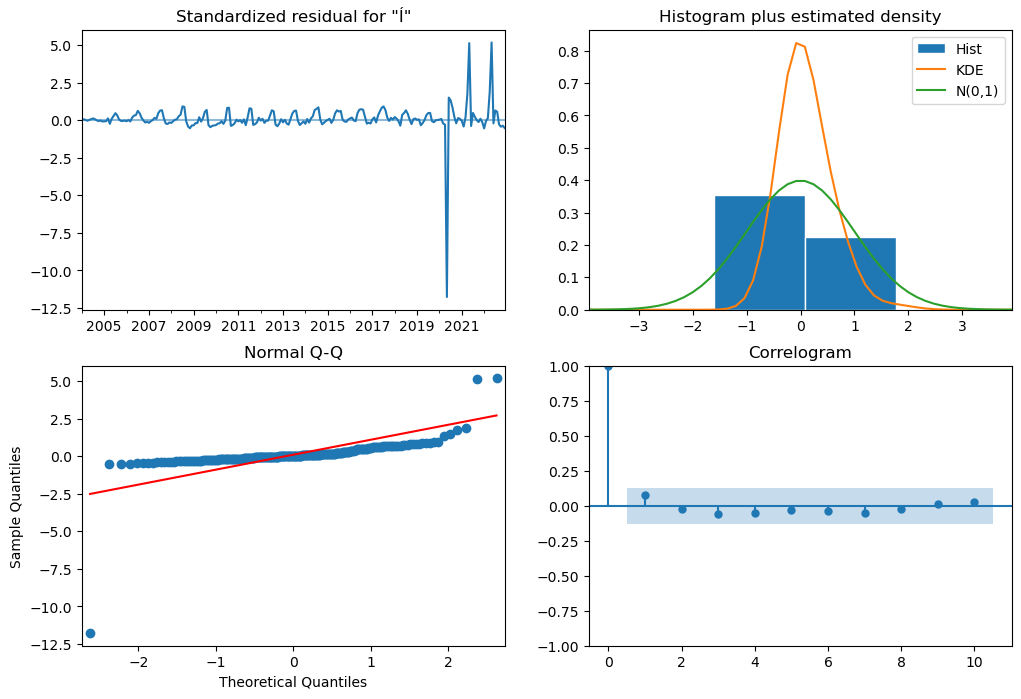

In [33]:
# Validate the model
results_1.plot_diagnostics(figsize=(12, 8))
plt.show()

In [34]:
# Calculate the MSE
print('MSE: ' + str(results_1.mse))

# Calculate the MAE
print('MAE: ' + str(results_1.mae))

MSE: 647.060178934392
MAE: 9.306425817522882


In [35]:
# Estimation of predictions
predictions_1 = results_1.get_forecast(steps=12)
predi_test_1 = predictions_1.predicted_mean
print(predi_test_1)

2023-01-01    143.919773
2023-02-01    145.399962
2023-03-01    141.127897
2023-04-01    151.414871
2023-05-01    145.817025
2023-06-01    161.011073
2023-07-01    177.858818
2023-08-01    180.342364
2023-09-01    155.695025
2023-10-01    145.315203
2023-11-01    146.313601
2023-12-01    147.451375
Freq: MS, Name: predicted_mean, dtype: float64


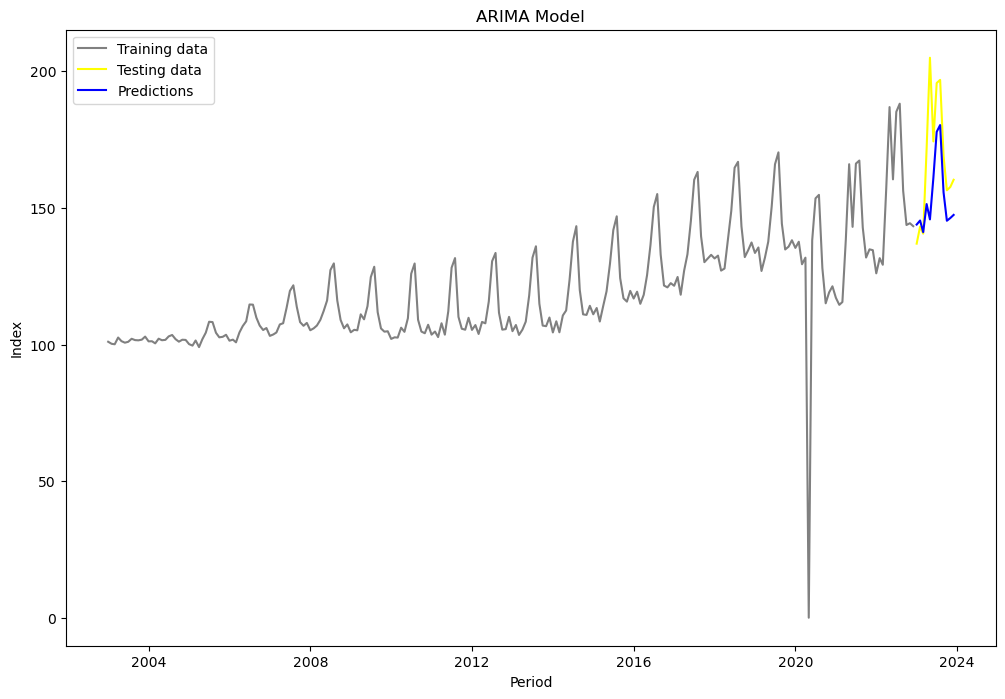

In [36]:
# Visualize the training and testing sets with the ARIMA model predictions
plt.figure(figsize=(12, 8))
plt.plot(train, label='Training data', color='gray')
plt.plot(test, label='Testing data', color='yellow')
plt.plot(predictions_1.predicted_mean, label='Predictions', color='blue') 
plt.xlabel('Period')
plt.ylabel('Index')
plt.title('ARIMA Model')
plt.legend()
plt.show()

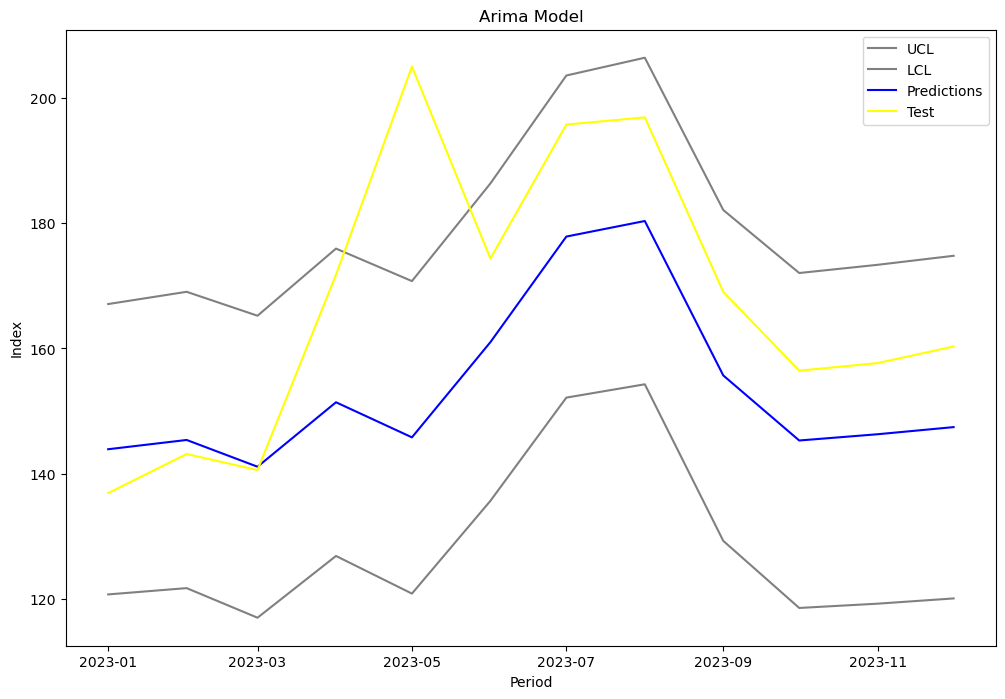

In [37]:
# Calculate the confidence intervals for the predictions
intervalos_confianza = predictions_1.conf_int()
plt.figure(figsize=(12, 8))
plt.plot(intervalos_confianza['lower Índice'], label='UCL', color='gray')
plt.plot(intervalos_confianza['upper Índice'], label='LCL', color='gray')
plt.plot(predi_test_1, label='Predictions', color='blue')
plt.plot(test, label='Test', color='yellow')
plt.xlabel('Period')
plt.ylabel('Index')
plt.title('Arima Model')
plt.legend()
plt.show()

### Application of the automatic seasonal ARIMA model

In [38]:
# Generate the automatic seasonal ARIMA model
modelo_auto = pm.auto_arima(
    train, 
    start_p = 1, start_q=1,
    max_p=3, max_q=3, 
    m=12, start_P=0, 
    seasonal=True,
    d=0, D=1, 
    trace=True,
    error_action='ignore',suppress_warnings=True,
    stepwise=True
    ) 

print(modelo_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1789.222, Time=1.46 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1901.701, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1857.467, Time=0.54 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1803.305, Time=0.53 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1906.934, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=1889.912, Time=0.20 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=1791.186, Time=1.25 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=1791.143, Time=1.81 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1848.516, Time=0.66 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=1790.336, Time=1.96 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1795.738, Time=0.52 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=1789.657, Time=2.56 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=1789.772, Time=2.00 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1822.551, Time=0.28 sec
 ARIMA(0,0,2)(0,1,1

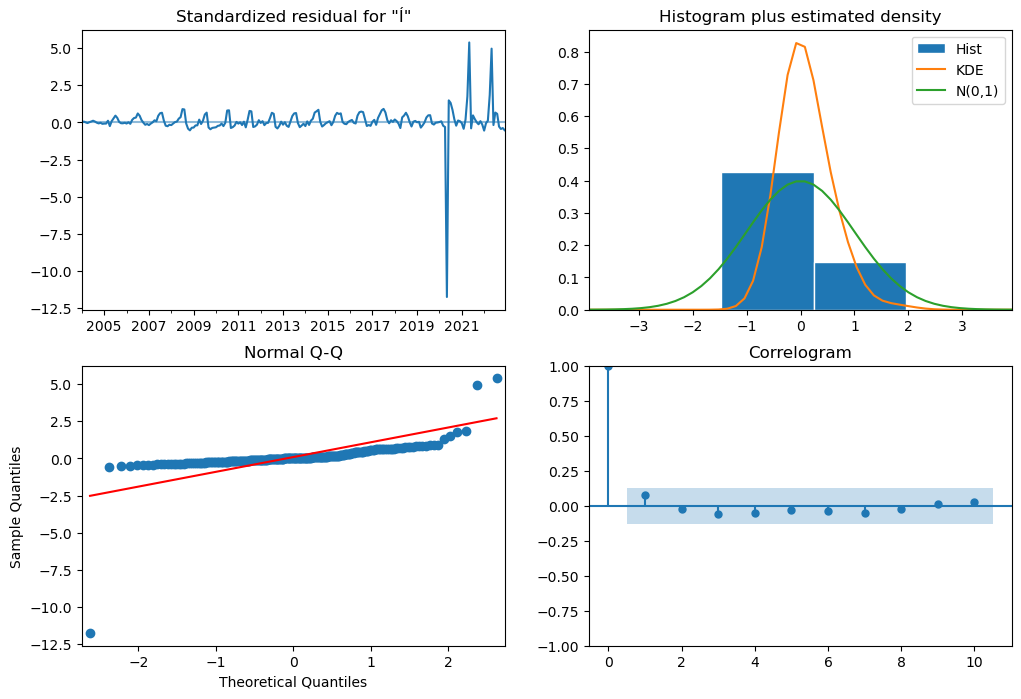

In [39]:
# Visualize the diagnostics of the automatic seasonal ARIMA model
best_arima = sm.tsa.ARIMA(train, order=(1, 0, 1), seasonal_order=(0, 1, 1, 12))
results_autom = best_arima.fit()
results_autom.plot_diagnostics(figsize=(12, 8))
plt.show()

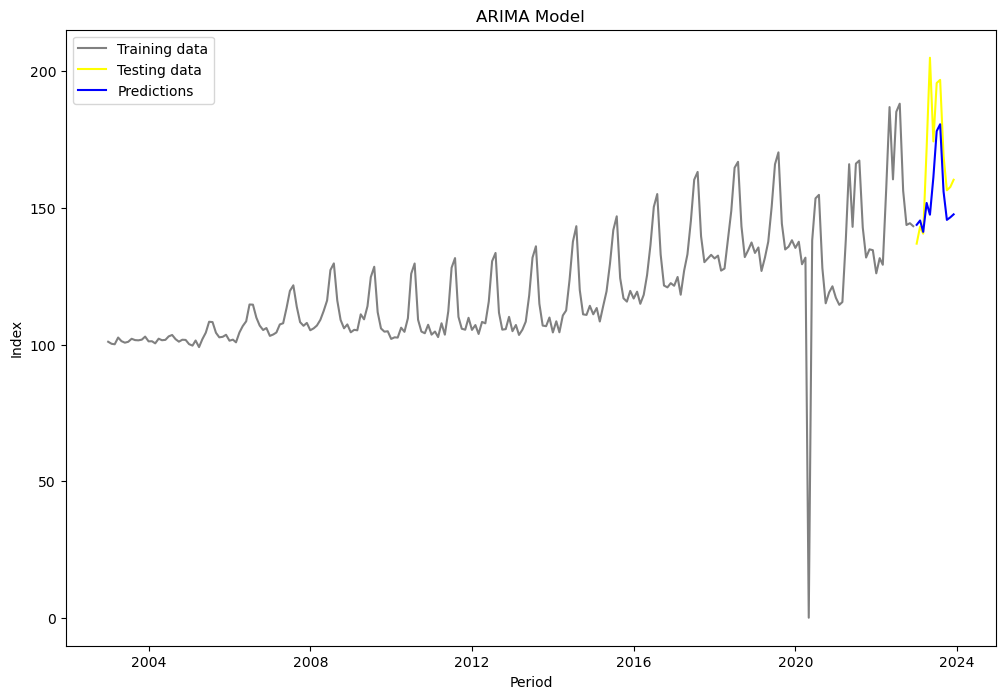

In [40]:
# Visulize the training and testing sets with the automatic seasonal ARIMA model predictions
prediciones_autom = results_autom.get_forecast(steps=12)
predi_test_autom =prediciones_autom.predicted_mean
intervalos_confianza_autom = prediciones_autom.conf_int()
plt.figure(figsize=(12, 8))
plt.plot(train, label='Training data', color='gray')
plt.plot(test, label='Testing data', color='yellow')
plt.plot(prediciones_autom.predicted_mean, label='Predictions', color='blue')
plt.xlabel('Period')
plt.ylabel('Index')
plt.title('ARIMA Model')
plt.legend()
plt.show()

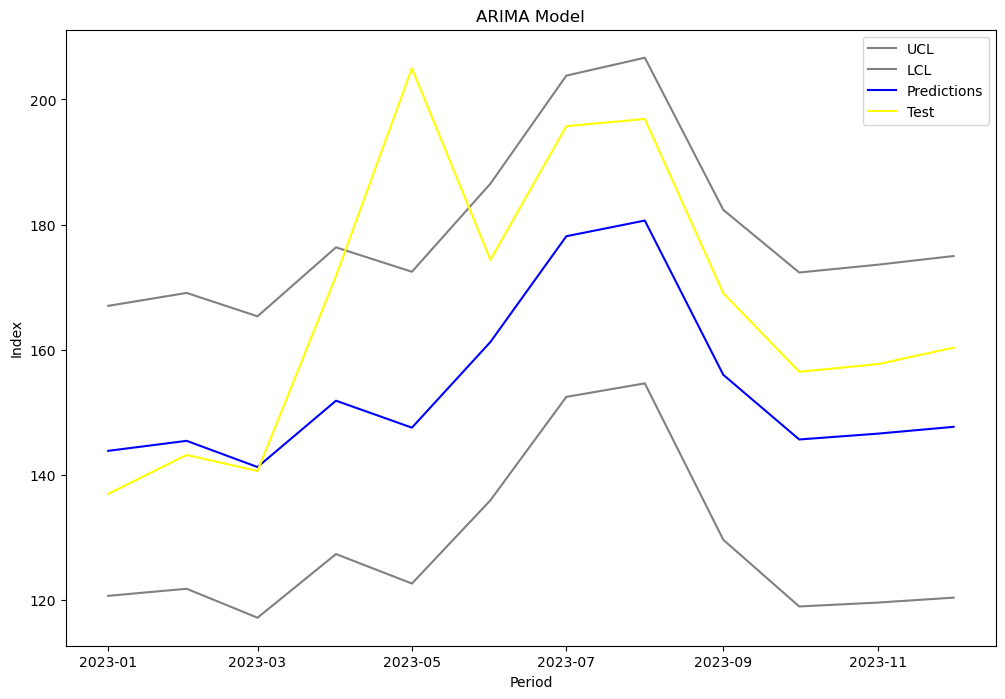

In [41]:
# Calculate the confidence intervals for the predictions
intervalos_confianza = prediciones_autom.conf_int()
plt.figure(figsize=(12, 8))
plt.plot(intervalos_confianza['lower Índice'], label='UCL', color='gray')
plt.plot(intervalos_confianza['upper Índice'], label='LCL', color='gray')
plt.plot(predi_test_autom, label='Predictions', color='blue')
plt.plot(test, label='Test', color='yellow')
plt.xlabel('Period')
plt.ylabel('Index')
plt.title('ARIMA Model')
plt.legend()
plt.show()

In [42]:
# Estimation of predictions
predi_test_autom = prediciones_autom.predicted_mean
print(predi_test_autom)

2023-01-01    143.813326
2023-02-01    145.413762
2023-03-01    141.227673
2023-04-01    151.831958
2023-05-01    147.522310
2023-06-01    161.218858
2023-07-01    178.129019
2023-08-01    180.636450
2023-09-01    155.972871
2023-10-01    145.632047
2023-11-01    146.563385
2023-12-01    147.655612
Freq: MS, Name: predicted_mean, dtype: float64


In [43]:
# Calculate the MSE
print('MSE: ' + str(results_autom.mse))

# Calculate the MAE
print('MAE: ' + str(results_autom.mae))

MSE: 647.2118880781098
MAE: 9.288408644784216


## ✅ Conclusions
- The IPAP time series shows strong seasonal patterns, especially during summer months.
- Holt-Winters and ARIMA models provided accurate forecasts, capturing both trend and seasonality.
- The analysis demonstrates the value of time series modeling for understanding and predicting tourism-related economic indicators.